# Kaggle Titanic Challence

This notebook is meant to generate a submission to the *Titanic* challenge on Kaggle. It contains content from, and is informed by, several older attemts, including one that was part of a course at General Assemply. 

In this run through, after cleaning the data, defining several new features, and studying feature importance, I train three different classifiers and generate seperate submissions for each. As of right now, the decision tree seems to do best.

## Import Packages

In [1]:
# Import useful packages
import numpy as np
import pandas as pd
from matplotlib import pyplot
import csv as csv
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.svm import SVC as SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.naive_bayes import GaussianNB

## Imprort and Clean the Data

In [2]:
# import training data
train = pd.read_csv('Data/train.csv')

# import testing data
test = pd.read_csv('Data/test.csv')

In [3]:
# What do we have in train?
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Counts for categorical columns
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [6]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
train['Cabin'].value_counts()

G6                 4
B96 B98            4
C23 C25 C27        4
F33                3
C22 C26            3
D                  3
F2                 3
E101               3
D33                2
D35                2
E8                 2
B49                2
C68                2
D36                2
C123               2
D26                2
E121               2
C2                 2
C52                2
B57 B59 B63 B66    2
F4                 2
E67                2
C125               2
C83                2
B28                2
C126               2
B5                 2
D17                2
D20                2
B58 B60            2
                  ..
D56                1
E36                1
D47                1
D50                1
E50                1
B4                 1
B94                1
C90                1
D19                1
C49                1
D49                1
C45                1
A36                1
E38                1
E10                1
C82                1
E12          

### Fill missing data and define features:

In [9]:
# Replace sex by an int, male=1, female=0
train['Gender'] = train.apply(lambda x: int(x['Sex']== 'male'), axis=1)
test['Gender'] = test.apply(lambda x: int(x['Sex']== 'male'), axis=1)

# Fill missing age data

# For each combination of Sex and PClass, compute the median age of passengers in that group. Save the result in a dict.
median_age_lookup = {}
median_age_lookup[('male',1)] = train[(train['Sex']=='male') & (train['Pclass'] == 1)].Age.median()
median_age_lookup[('male',2)] = train[(train['Sex']=='male') & (train['Pclass'] == 2)].Age.median()
median_age_lookup[('male',3)] = train[(train['Sex']=='male') & (train['Pclass'] == 3)].Age.median()
median_age_lookup[('female',1)] = train[(train['Sex']=='female') & (train['Pclass'] == 1)].Age.median()
median_age_lookup[('female',2)] = train[(train['Sex']=='female') & (train['Pclass'] == 2)].Age.median()
median_age_lookup[('female',3)] = train[(train['Sex']=='female') & (train['Pclass'] == 3)].Age.median()


# Fill missing ages by median age of passengers with same Sex and Pclass.
test['DefaultAge'] = test.apply(lambda x: median_age_lookup[(x['Sex'], x['Pclass'])], axis=1)
test.Age.fillna(test['DefaultAge'], inplace=True)

train['DefaultAge'] = train.apply(lambda x: median_age_lookup[(x['Sex'], x['Pclass'])], axis=1)
train.Age.fillna(train['DefaultAge'], inplace=True)

#Fill missing fare data. We will treat it much the same as Age above.
# Build the dict of median fares:
median_fare_lookup = {}
median_fare_lookup[('male',1)] = train[(train['Sex']=='male') & (train['Pclass'] == 1)].Fare.median()
median_fare_lookup[('male',2)] = train[(train['Sex']=='male') & (train['Pclass'] == 2)].Fare.median()
median_fare_lookup[('male',3)] = train[(train['Sex']=='male') & (train['Pclass'] == 3)].Fare.median()
median_fare_lookup[('female',1)] = train[(train['Sex']=='female') & (train['Pclass'] == 1)].Fare.median()
median_fare_lookup[('female',2)] = train[(train['Sex']=='female') & (train['Pclass'] == 2)].Fare.median()
median_fare_lookup[('female',3)] = train[(train['Sex']=='female') & (train['Pclass'] == 3)].Fare.median()

# Replace missing Fare by median Fare.
test['DefaultFare'] = test.apply(lambda x: median_fare_lookup[(x['Sex'], x['Pclass'])], axis=1)
test.Fare.fillna(test['DefaultFare'], inplace=True)

train['DefaultFare'] = train.apply(lambda x: median_fare_lookup[(x['Sex'], x['Pclass'])], axis=1)
train.Fare.fillna(test['DefaultFare'], inplace=True)

#Fill missing embarkation data. Since 'S' is most common, we will use that one to fill in missing data.
train.Embarked.fillna('S', inplace=True)
test.Embarked.fillna('S', inplace=True)

#Cabin value null or not
train['CabinNull'] = train['Cabin'].isnull()
test['CabinNull'] = test['Cabin'].isnull()

train['CabinNull'] = train.apply(lambda x: 1 if x['CabinNull'] else 0, axis=1)
test['CabinNull'] = test.apply(lambda x: 1 if x['CabinNull'] else 0, axis=1)

#And other data just in case
train.Pclass.fillna(3, inplace=True)
train.SibSp.fillna(0, inplace=True)
train.Parch.fillna(0, inplace=True)

test.Pclass.fillna(3, inplace=True)
test.SibSp.fillna(0, inplace=True)
test.Parch.fillna(0, inplace=True)

#Create columns for each point of departure
train['EmbarkedS'] = (train['Embarked']=='S').astype(int)
train['EmbarkedQ'] = (train['Embarked']=='Q').astype(int)
train['EmbarkedC'] = (train['Embarked']=='C').astype(int)

test['EmbarkedS'] = (test['Embarked']=='S').astype(int)
test['EmbarkedQ'] = (test['Embarked']=='Q').astype(int)
test['EmbarkedC'] = (test['Embarked']=='C').astype(int)

#pd.get_dummies(train, columns=['Embarked'], drop_first = True)
#pd.get_dummies(test, columns=['Embarked'], drop_first = True)

# No Family feature

train['no_sibs'] = train.apply(lambda x: 1 if x['SibSp']==0 else 0, axis=1)
train['no_parch'] = train.apply(lambda x: 1 if  x['Parch']==0 else 0, axis=1)
train['no_family'] = train.apply(lambda x: 1 if x['no_sibs'] and x['no_parch'] else 0, axis=1)
train['FamilyCount'] = train['SibSp'] + train['Parch']

test['no_sibs'] = test.apply(lambda x: 1 if x['SibSp']==0 else 0, axis=1)
test['no_parch'] = test.apply(lambda x: 1 if  x['Parch']==0 else 0, axis=1)
test['no_family'] = test.apply(lambda x: 1 if x['no_sibs'] and x['no_parch'] else 0, axis=1)
test['FamilyCount'] = test['SibSp'] + test['Parch']

#Split Name

train['Surname'] = train.apply(lambda x: x['Name'].split(',')[0], axis=1)
test['Surname'] = test.apply(lambda x: x['Name'].split(",")[0], axis=1)

train['Title'] = train.apply(lambda x: x['Name'].split(',')[1].split(".")[0], axis=1)
test['Title'] = test.apply(lambda x: x['Name'].split(',')[1].split(".")[0], axis=1)

train['First_Name'] = train.apply(lambda x: x['Name'].split(',')[1].split(".")[1], axis=1)
test['First_Name'] = test.apply(lambda x: x['Name'].split(',')[1].split(".")[1], axis=1)

#Create title columns
train['Miss'] = (train.apply(lambda x: 'Miss.' in x['Name'] or 'Ms' in x['Name'] or 'Mlle' in x['Name'], axis=1)).astype(int)
train['Mrs'] = (train.apply(lambda x: 'Mrs.' in x['Name'] or 'Mme' in x['Name'], axis=1)).astype(int)
train['Mr'] = (train.apply(lambda x: 'Mr.' in x['Name'], axis=1)).astype(int)
train['Master'] = (train.apply(lambda x: 'Master' in x['Name'], axis=1)).astype(int)
train['Rev'] = (train.apply(lambda x: 'Rev.' in x['Name'], axis=1)).astype(int)
train['Dr'] = (train.apply(lambda x: 'Dr.' in x['Name'], axis=1)).astype(int)
train['Military'] = (train.apply(lambda x: 'Capt' in x['Name'] or 'Col' in x['Name'] or 'Major' in x['Name'], axis=1)).astype(int)
train['Titled'] = (train.apply(lambda x: 'Don' in x['Name'] or 'Donna' in x['Name']  or 'Sir' in x['Name'] or 'Countess' in x['Name'] or 'Lady' in x['Name'] or ' Jonkheer' in x['Name'], axis=1)).astype(int)


test['Miss'] = (test.apply(lambda x: 'Miss.' in x['Name'] or 'Ms' in x['Name'] or 'Mlle' in x['Name'], axis=1)).astype(int)
test['Mrs'] = (test.apply(lambda x: 'Mrs.' in x['Name'] or 'Mme' in x['Name'], axis=1)).astype(int)
test['Mr'] = (test.apply(lambda x: 'Mr.' in x['Name'], axis=1)).astype(int)
test['Rev'] = (test.apply(lambda x: 'Rev.' in x['Name'], axis=1)).astype(int)
test['Dr'] = (test.apply(lambda x: 'Dr.' in x['Name'], axis=1)).astype(int)
test['Master'] = (test.apply(lambda x: 'Master' in x['Name'], axis=1)).astype(int)
test['Military'] = (test.apply(lambda x: 'Capt' in x['Name'] or 'Col' in x['Name'] or 'Major' in x['Name'], axis=1)).astype(int)
test['Titled'] = (test.apply(lambda x: 'Don' in x['Name'] or 'Donna' in x['Name']  or 'Sir' in x['Name'] or 'Countess' in x['Name'] or 'Lady' in x['Name'] or ' Jonkheer' in x['Name'], axis=1)).astype(int)

#Get surname counts
train['SurnameCount'] = train.groupby('Surname')['Surname'].transform('count')
test['SurnameCount'] = test.groupby('Surname')['Surname'].transform('count')

# Modernize Fare
train['Fare2018USD'] = 145*train['Fare']
test['Fare2018USD'] = 145*test['Fare']

#Create age categories
train['Child'] = train.apply(lambda x: int(x['Age']<12), axis=1)
train['Teen'] = train.apply(lambda x: int(x['Age']<18 and x['Age']>12), axis=1)
train['YoungAdult'] = train.apply(lambda x: int(x['Age']>=18 and x['Age']<31), axis=1)
train['Elderly'] = train.apply(lambda x: int(x['Age']>=60), axis=1)

test['Child'] = test.apply(lambda x: int(x['Age']<12), axis=1)
test['Teen'] = test.apply(lambda x: int(x['Age']<18 and x['Age']>12), axis=1)
test['YoungAdult'] = test.apply(lambda x: int(x['Age']>=18 and x['Age']<31), axis=1)
test['Elderly'] = test.apply(lambda x: int(x['Age']>=60), axis=1)

#Motherhood
train['Mother']= train.apply(lambda x: int(x['Age']>16 and x['Parch']>0 and not x['Sex']=='male'), axis=1)
test['Mother']= test.apply(lambda x: int(x['Age']>16 and x['Parch']>0 and not x['Sex']=='male'), axis=1)

#Save modified csv files
train.to_csv("trainDecorated.csv")
test.to_csv("testDecorated.csv")

In [10]:
# Check for remaining null values:
train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          0
Gender            0
DefaultAge        0
DefaultFare       0
CabinNull         0
EmbarkedS         0
EmbarkedQ         0
EmbarkedC         0
no_sibs           0
no_parch          0
no_family         0
FamilyCount       0
Surname           0
Title             0
First_Name        0
Miss              0
Mrs               0
Mr                0
Master            0
Rev               0
Dr                0
Military          0
Titled            0
SurnameCount      0
Fare2018USD       0
Child             0
Teen              0
YoungAdult        0
Elderly           0
Mother            0
dtype: int64

In [11]:
test.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           327
Embarked          0
Gender            0
DefaultAge        0
DefaultFare       0
CabinNull         0
EmbarkedS         0
EmbarkedQ         0
EmbarkedC         0
no_sibs           0
no_parch          0
no_family         0
FamilyCount       0
Surname           0
Title             0
First_Name        0
Miss              0
Mrs               0
Mr                0
Rev               0
Dr                0
Master            0
Military          0
Titled            0
SurnameCount      0
Fare2018USD       0
Child             0
Teen              0
YoungAdult        0
Elderly           0
Mother            0
dtype: int64

In [12]:
# List of our columns
train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Gender',
       'DefaultAge', 'DefaultFare', 'CabinNull', 'EmbarkedS', 'EmbarkedQ',
       'EmbarkedC', 'no_sibs', 'no_parch', 'no_family', 'FamilyCount',
       'Surname', 'Title', 'First_Name', 'Miss', 'Mrs', 'Mr', 'Master',
       'Rev', 'Dr', 'Military', 'Titled', 'SurnameCount', 'Fare2018USD',
       'Child', 'Teen', 'YoungAdult', 'Elderly', 'Mother'], dtype=object)

### Eyeball data

In [13]:
# Survival rate, age Fare, etc. by Pclass
train.groupby('Pclass').mean()[['Survived','Age','Fare','FamilyCount','Gender']]

,Survived,Age,Fare,FamilyCount,Gender
Pclass,,,,,
1,0.629630,38.270463,84.154687,0.773148,0.564815
2,0.472826,29.863207,20.662183,0.782609,0.586957
3,0.242363,24.802281,13.675550,1.008147,0.706721


In [14]:
# Same as above, but by Sex
train.groupby('Sex').mean()[['Survived','Age','Fare','FamilyCount','Pclass']]

,Survived,Age,Fare,FamilyCount,Pclass
Sex,,,,,
female,0.742038,27.261146,44.479818,1.343949,2.159236
male,0.188908,30.119879,25.523893,0.665511,2.389948


In [15]:
# Same as above, but for Embarkation point
train.groupby('Embarked').mean()[['Survived','Age','Fare','FamilyCount','Gender','Pclass']]

,Survived,Age,Fare,FamilyCount,Gender,Pclass
Embarked,,,,,,
C,0.553571,30.246548,59.954144,0.750000,0.565476,1.886905
Q,0.389610,25.116883,13.276030,0.597403,0.532468,2.909091
S,0.339009,29.293731,27.243651,0.981424,0.682663,2.346749


In [16]:
# Highest Fares
train.sort_values('Fare',ascending=False).head()[['Fare','Survived','Name']]

,Fare,Survived,Name
258,512.3292,1,"Ward, Miss. Anna"
737,512.3292,1,"Lesurer, Mr. Gustave J"
679,512.3292,1,"Cardeza, Mr. Thomas Drake Martinez"
88,263.0000,1,"Fortune, Miss. Mabel Helen"
27,263.0000,0,"Fortune, Mr. Charles Alexander"


In [17]:
# Look at Survival etc. by Pclass and Sex together
train.groupby(['Pclass', 'Sex']).agg(['mean','count'])[['Survived','Age','Fare','FamilyCount']]

Survived              Age              Fare       FamilyCount  \
                   mean count       mean count        mean count        mean   
Pclass Sex                                                                     
1      female  0.968085    94  34.648936    94  106.125798    94    1.010638   
       male    0.368852   122  41.060820   122   67.226127   122    0.590164   
2      female  0.921053    76  28.703947    76   21.970121    76    1.092105   
       male    0.157407   108  30.678981   108   19.741782   108    0.564815   
3      female  0.500000   144  21.677083   144   16.118810   144    1.694444   
       male    0.135447   347  26.099193   347   12.661633   347    0.723343   

                     
              count  
Pclass Sex           
1      female    94  
       male     122  
2      female    76  
       male     108  
3      female   144  
       male     347

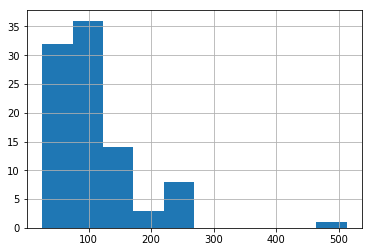

In [18]:
train.query("Gender == 0 and Pclass == 1")['Fare'].hist()

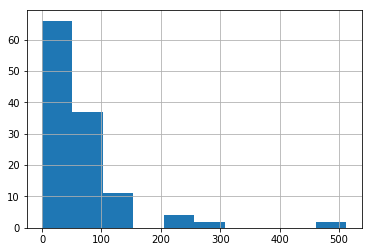

In [19]:
train.query("Gender == 1 and Pclass == 1")['Fare'].hist()

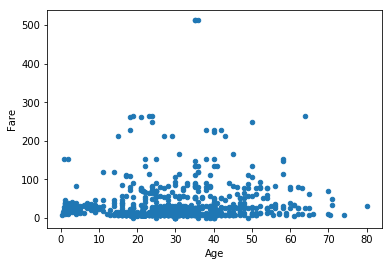

In [20]:
# Age and Fare are correlated:
train.plot.scatter('Age','Fare')

In [21]:
# Percentage of passengers with Fare less that 10, 20, and 5:
train.query("Fare<10")['PassengerId'].count()/train['PassengerId'].count()

0.3771043771043771

In [22]:
train.query("Fare<20")['PassengerId'].count()/train['PassengerId'].count()

0.5780022446689114

In [23]:
train.query("Fare<5")['PassengerId'].count()/train['PassengerId'].count()

0.017957351290684626

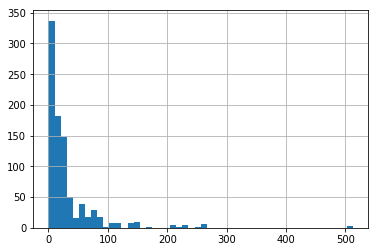

In [24]:
# Histogram of Fares
train['Fare'].hist(bins=50)

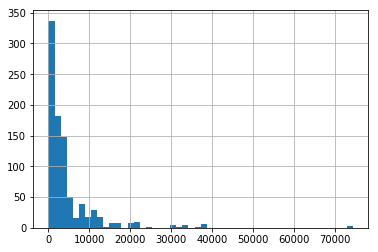

In [25]:
# Rescaled x-axis to 2018 USD
train['Fare2018USD'].hist(bins=50)

In [26]:
train['Fare2018USD'].describe()

count      891.000000
mean      4669.610155
std       7205.547147
min          0.000000
25%       1147.008000
50%       2095.859000
75%       4495.000000
max      74287.734000
Name: Fare2018USD, dtype: float64

In [27]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [28]:
train.query("Age < 18")['Survived'].mean()

0.5398230088495575

In [29]:
train.sort_values('Age',ascending=False)[['Name','Survived','Age','Pclass','Fare']]

,Name,Survived,Age,Pclass,Fare
630,"Barkworth, Mr. Algernon Henry Wilson",1,80.00,1,30.0000
851,"Svensson, Mr. Johan",0,74.00,3,7.7750
493,"Artagaveytia, Mr. Ramon",0,71.00,1,49.5042
96,"Goldschmidt, Mr. George B",0,71.00,1,34.6542
116,"Connors, Mr. Patrick",0,70.50,3,7.7500
672,"Mitchell, Mr. Henry Michael",0,70.00,2,10.5000
745,"Crosby, Capt. Edward Gifford",0,70.00,1,71.0000
33,"Wheadon, Mr. Edward H",0,66.00,2,10.5000
280,"Duane, Mr. Frank",0,65.00,3,7.7500
456,"Millet, Mr. Francis Davis",0,65.00,1,26.5500


In [30]:
# Drop Cabin, DefaultAge, and DefaultFare:
train = train.drop(['Cabin','DefaultAge','DefaultFare'], axis=1)
test = test.drop(['Cabin','DefaultAge','DefaultFare'], axis=1)

In [31]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,CabinNull,EmbarkedS,...,Dr,Military,Titled,SurnameCount,Fare2018USD,Child,Teen,YoungAdult,Elderly,Mother
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.112424,0.523008,0.381594,32.204208,0.647587,0.771044,0.725028,...,0.007856,0.014590,0.008979,1.882155,4669.610155,0.076319,0.049383,0.499439,0.029181,0.093154
std,257.353842,0.486592,0.836071,13.304424,1.102743,0.806057,49.693429,0.477990,0.420397,0.446751,...,0.088337,0.119973,0.094383,1.488014,7205.547147,0.265657,0.216787,0.500281,0.168407,0.290811
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.500000,0.000000,0.000000,7.910400,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1147.008000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,2095.859000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,2.000000,4495.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.000000,74287.734000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
correlations = train.drop(['PassengerId','Fare2018USD'], axis=1).corr()

In [33]:
correlations

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,CabinNull,EmbarkedS,EmbarkedQ,...,Rev,Dr,Military,Titled,SurnameCount,Child,Teen,YoungAdult,Elderly,Mother
Survived,1.000000,-0.338481,-0.059579,-0.035322,0.081629,0.257307,-0.543351,-0.316912,-0.149683,0.003650,...,-0.064988,0.008185,-0.019052,-0.001730,-0.049188,0.112119,0.043789,-0.128352,-0.040857,0.199629
Pclass,-0.338481,1.000000,-0.413583,0.083081,0.018443,-0.549500,0.131900,0.725541,0.074053,0.221009,...,-0.030413,-0.108935,-0.089751,-0.092113,0.113262,0.111356,0.052195,0.337544,-0.159798,-0.067550
Age,-0.059579,-0.413583,1.000000,-0.249854,-0.175526,0.122692,0.102706,-0.277022,0.022141,-0.092418,...,0.087028,0.084335,0.097521,0.064515,-0.212115,-0.528504,-0.229238,-0.375525,0.469173,0.056678
SibSp,-0.035322,0.083081,-0.249854,1.000000,0.414838,0.159651,-0.114631,0.040460,0.068734,-0.026354,...,-0.026622,0.003910,-0.032265,-0.012783,0.667568,0.354531,0.061042,-0.089081,-0.045971,0.152727
Parch,0.081629,0.018443,-0.175526,0.414838,1.000000,0.216225,-0.245489,-0.036987,0.060814,-0.081228,...,-0.021967,-0.042150,0.000456,-0.045086,0.600538,0.372819,0.033499,-0.186152,-0.015904,0.562385
Fare,0.257307,-0.549500,0.122692,0.159651,0.216225,1.000000,-0.182333,-0.482075,-0.162184,-0.117216,...,-0.023031,0.030395,-0.016156,0.017924,0.105880,-0.002138,-0.006784,-0.175507,0.039319,0.170281
Gender,-0.543351,0.131900,0.102706,-0.114631,-0.245489,-0.182333,1.000000,0.140391,0.119224,-0.074115,...,0.060741,0.039034,0.050577,0.020405,-0.118485,-0.071106,-0.081257,0.041460,0.072063,-0.434467
CabinNull,-0.316912,0.725541,-0.277022,0.040460,-0.036987,-0.482075,0.140391,1.000000,0.101139,0.129572,...,0.044868,-0.042277,-0.045080,-0.061403,0.052016,0.045968,0.025571,0.261166,-0.111841,-0.082684
EmbarkedS,-0.149683,0.074053,0.022141,0.068734,0.060814,-0.162184,0.119224,0.101139,1.000000,-0.499421,...,0.019972,-0.030612,0.053973,-0.074618,0.086416,0.044478,-0.045260,-0.068559,0.002229,0.024411
EmbarkedQ,0.003650,0.221009,-0.092418,-0.026354,-0.081228,-0.117216,-0.074115,0.129572,-0.499421,1.000000,...,0.023515,0.017874,-0.037425,-0.029275,-0.013230,-0.028231,-0.014794,0.164112,-0.005860,-0.057347


In [53]:
# Identify which variables have the highest and lowest correlations with survival:
correlations.sort_values('Survived')['Survived']

Mr             -0.549199
Gender         -0.543351
Pclass         -0.338481
CabinNull      -0.316912
no_family      -0.203367
EmbarkedS      -0.149683
no_parch       -0.147408
YoungAdult     -0.128352
no_sibs        -0.115867
Rev            -0.064988
Age            -0.059579
SurnameCount   -0.049188
Elderly        -0.040857
SibSp          -0.035322
Military       -0.019052
Titled         -0.001730
EmbarkedQ       0.003650
Dr              0.008185
FamilyCount     0.016639
Teen            0.043789
Parch           0.081629
Master          0.085221
Child           0.112119
EmbarkedC       0.168240
Mother          0.199629
Fare            0.257307
Miss            0.335636
Mrs             0.341994
Survived        1.000000
Name: Survived, dtype: float64

In [54]:
correlations.sort_values('Survived')[['Survived','Mr','Gender','Pclass','no_family','Mrs','Miss','Fare','EmbarkedC','Mother','CabinNull']]

,Survived,Mr,Gender,Pclass,no_family,Mrs,Miss,Fare,EmbarkedC,Mother,CabinNull
Mr,-0.549199,1.000000,0.867334,0.142698,0.396920,-0.477160,-0.601857,-0.183766,-0.072567,-0.376828,0.137319
Gender,-0.543351,0.867334,1.000000,0.131900,0.303646,-0.550146,-0.693916,-0.182333,-0.082853,-0.434467,0.140391
Pclass,-0.338481,0.142698,0.131900,1.000000,0.135207,-0.153758,-0.010261,-0.549500,-0.243292,-0.067550,0.725541
CabinNull,-0.316912,0.137319,0.140391,0.725541,0.158029,-0.123817,-0.043749,-0.482075,-0.208528,-0.082684,1.000000
no_family,-0.203367,0.396920,0.303646,0.135207,1.000000,-0.361624,-0.048054,-0.271832,-0.095298,-0.394747,0.158029
EmbarkedS,-0.149683,0.112870,0.119224,0.074053,0.029074,-0.002550,-0.137144,-0.162184,-0.782742,0.024411,0.101139
no_parch,-0.147408,0.381733,0.247523,0.027526,0.690336,-0.195434,-0.128289,-0.237717,-0.032550,-0.571819,0.089136
YoungAdult,-0.128352,0.144591,0.041460,0.337544,0.200923,-0.115499,0.058682,-0.175507,-0.039629,0.011944,0.261166
no_sibs,-0.115867,0.294116,0.203203,0.076009,0.840286,-0.276603,-0.001428,-0.192190,-0.034759,-0.179471,0.075769
Rev,-0.064988,-0.096808,0.060741,-0.030413,0.010764,-0.033416,-0.042149,-0.023031,-0.039691,-0.026390,0.044868


In [55]:
train[['Survived','Mr','Gender','Pclass','no_family','Mrs','Miss','Fare','EmbarkedC','Mother','CabinNull']].corr()

,Survived,Mr,Gender,Pclass,no_family,Mrs,Miss,Fare,EmbarkedC,Mother,CabinNull
Survived,1.000000,-0.549199,-0.543351,-0.338481,-0.203367,0.341994,0.335636,0.257307,0.168240,0.199629,-0.316912
Mr,-0.549199,1.000000,0.867334,0.142698,0.396920,-0.477160,-0.601857,-0.183766,-0.072567,-0.376828,0.137319
Gender,-0.543351,0.867334,1.000000,0.131900,0.303646,-0.550146,-0.693916,-0.182333,-0.082853,-0.434467,0.140391
Pclass,-0.338481,0.142698,0.131900,1.000000,0.135207,-0.153758,-0.010261,-0.549500,-0.243292,-0.067550,0.725541
no_family,-0.203367,0.396920,0.303646,0.135207,1.000000,-0.361624,-0.048054,-0.271832,-0.095298,-0.394747,0.158029
Mrs,0.341994,-0.477160,-0.550146,-0.153758,-0.361624,1.000000,-0.207749,0.107259,0.067872,0.490517,-0.123817
Miss,0.335636,-0.601857,-0.693916,-0.010261,-0.048054,-0.207749,1.000000,0.119518,0.036204,0.092979,-0.043749
Fare,0.257307,-0.183766,-0.182333,-0.549500,-0.271832,0.107259,0.119518,1.000000,0.269335,0.170281,-0.482075
EmbarkedC,0.168240,-0.072567,-0.082853,-0.243292,-0.095298,0.067872,0.036204,0.269335,1.000000,0.013329,-0.208528
Mother,0.199629,-0.376828,-0.434467,-0.067550,-0.394747,0.490517,0.092979,0.170281,0.013329,1.000000,-0.082684


In [56]:
train_target = train['Survived']

In [96]:
# Define the full feature set, and make a csv with only these columns:

features_full = ['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Gender',
 'CabinNull',
 'EmbarkedS',
 'EmbarkedQ',
 'EmbarkedC',
 'no_sibs',
 'no_parch',
 'no_family',
 'FamilyCount',
 'Miss',
 'Mrs',
 'Mr',
 'Master',
 'Rev',
 'Dr',
 'Military',
 'Titled',
 'SurnameCount',
 'Child',
 'Teen',
 'YoungAdult',
 'Elderly',
 'Mother']

train_full = train[features_full]
test_full = test[features_full]

train_full.head()

,Pclass,Age,SibSp,Parch,Fare,Gender,CabinNull,EmbarkedS,EmbarkedQ,EmbarkedC,...,Rev,Dr,Military,Titled,SurnameCount,Child,Teen,YoungAdult,Elderly,Mother
0,3,22.0,1,0,7.2500,1,1,1,0,0,...,0,0,0,0,2,0,0,1,0,0
1,1,38.0,1,0,71.2833,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,3,26.0,0,0,7.9250,0,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0
3,1,35.0,1,0,53.1000,0,0,1,0,0,...,0,0,0,0,2,0,0,0,0,0
4,3,35.0,0,0,8.0500,1,1,1,0,0,...,0,0,0,0,2,0,0,0,0,0


### Use a desicion tree to study feature importance

In [58]:
# Create and train a descision tree:
tree = DecisionTree()
tree.fit(train_full, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [59]:
# Get feature importances from tree:
pd.DataFrame(tree.feature_importances_, columns=['Importance'], index= features_full).sort_values('Importance', ascending= False)

,Importance
Mr,0.310409
Fare,0.205206
Age,0.163370
FamilyCount,0.088140
Pclass,0.050294
SurnameCount,0.032762
SibSp,0.018801
Rev,0.016153
Parch,0.015891
CabinNull,0.015820


While the feature list below does not match the top $N$ most important features based on our tree, empirically it seems to give the best result for the DT classifier.

In [104]:
# Define list of best features:

#features_limited = ['Mr','Fare','Age','FamilyCount','Pclass','SurnameCount']
features_limited = ['Mr','Gender','Pclass','no_family','Mrs','Miss','Fare','EmbarkedC','Mother','CabinNull']

In [105]:
train_limited = train[features_limited]
train_limited.head()

,Mr,Gender,Pclass,no_family,Mrs,Miss,Fare,EmbarkedC,Mother,CabinNull
0,1,1,3,0,0,0,7.2500,0,0,1
1,0,0,1,0,1,0,71.2833,1,0,0
2,0,0,3,1,0,1,7.9250,0,0,1
3,0,0,1,0,1,0,53.1000,0,0,0
4,1,1,3,1,0,0,8.0500,0,0,1


In [106]:
test_limited = test[features_limited]
test_limited.head()

,Mr,Gender,Pclass,no_family,Mrs,Miss,Fare,EmbarkedC,Mother,CabinNull
0,1,1,3,1,0,0,7.8292,0,0,1
1,0,0,3,0,1,0,7.0000,0,0,1
2,1,1,2,1,0,0,9.6875,0,0,1
3,1,1,3,1,0,0,8.6625,0,0,1
4,0,0,3,0,1,0,12.2875,0,1,1


### Train Models Based on Best Features

To avoid overfitting, I will only use the limited set of features to generate a submission from a decision tree.

In [107]:
# Create and train another descision tree:
tree2 = DecisionTree()
tree2.fit(train_limited, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [108]:
# Get feature importances from tree:
pd.DataFrame(tree2.feature_importances_, columns=['Importance'], index= features_limited).sort_values('Importance', ascending= False)

,Importance
Fare,0.392564
Mr,0.382778
Pclass,0.101989
Gender,0.035722
no_family,0.035577
CabinNull,0.018593
EmbarkedC,0.015910
Mother,0.011017
Miss,0.004182
Mrs,0.001667


In [89]:
# Make predictions based on decision tree:
predict_DT = pd.DataFrame(columns = ['Survived'], index = test['PassengerId'])
predict_DT['Survived'] = tree2.predict(test_limited)
predict_DT.to_csv("predict_DT.csv")

I also use the limited feature set for SVN:

In [102]:
# Create and train SVC
svc = SVC()
svc.fit(train_limited, train_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [103]:
# Make predictions based on SVC:
predict_SVC = pd.DataFrame(columns = ['Survived'], index = test['PassengerId'])
predict_SVC['Survived'] = svc.predict(test_limited)
predict_SVC.to_csv("predict_SVC.csv")

Due to the nature of multi-layer perceptron, for this classifier I use the full feature list rather than the limited one.

In [95]:
# Create and train multi-layer perceptron
mlp = MLP(hidden_layer_sizes=(50,15,3), random_state=1)
mlp.fit(train_full, train_target)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 15, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [97]:
# Make predictions based on MLP:
predict_MLP = pd.DataFrame(columns = ['Survived'], index = test['PassengerId'])
predict_MLP['Survived'] = mlp.predict(test_full)
predict_MLP.to_csv("predict_MLP.csv")

### Future Improvements:

- Improve predictions by ensembling classifiers
- Do more optimization